(quality-control)=
# Quality Control
```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: preprocessing-visualization-quality-control-key-takeaway-1
:link-type: ref
Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
:::

:::{card}
:link: preprocessing-visualization-quality-control-key-takeaway-2
:link-type: ref
Feature-based filtering does not show benefits for downstream tasks.
:::

:::{card}
:link: preprocessing-visualization-quality-control-key-takeaway-3
:link-type: ref
Doublets can be efficiently detected with tools like scDblFinder.
:::

:::{card}
:link: preprocessing-visualization-quality-control-key-takeaway-4
:link-type: ref
Doublet detection methods should not be run on aggregated scRNA-seq data representing multiple batches.
:::

```
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} preprocessing_visualization.yml
:language: yaml
```
````

`````
``````
````{dropdown} <i class="fa-solid fa-database"></i>   Get data and notebooks
```{include} ../_static/default_text_lamindb_setup.md
```
````
<!-- END DROPDOWNS -->


## Motivation

Single-cell RNA-seq datasets have two essential properties that one should have in mind when performing an analysis.
First, scRNA-seq data contains drop-outs, meaning there is an excessive number of zeros in the data due to the limitation of {term}`mRNA <Messenger RNA (mRNA)>`.
Second, the potential for correcting the data and performing quality control might be limited as the data may be confounded with biology.
It is therefore crucial to select preprocessing methods that are suitable for the underlying data without overcorrecting or removing biological effects.

The set of tools for analyzing single-cell {term}`RNA`-sequencing data is evolving fast due to new {term}`sequencing` technologies and a growing number of captured cells, measured genes, and identified cell populations {cite}`qc:Zappia2021`.
Many of these tools are dedicated to preprocessing, which aims to address the following analysis steps: 
1.	{term}`Doublet <Doublets>` detection
2.	Quality control
3.	Normalization
4.	Feature selection
5.	Dimensionality reduction.

The algorithms selected throughout this process can heavily affect downstream analysis and interpretation of the data.
For example, if you filter out too many cells during quality control, you might lose rare cell subpopulations and miss insight into interesting cell biology.
Whereas if you are too permissive, you might have a hard time annotating your cells if you did not exclude poor-quality cells in your preprocessing pipeline.
In many cases, you will still have to re-assess your preprocessing analysis at a later point and change, for example, the filtering strategy.

The starting point of this notebook is single-cell data that has been processed as previously described in the [raw data processing chapter](../introduction/raw_data_processing.md).
The data was aligned to obtain matrices of molecular counts, the so-called count matrices, or read counts (read matrices).
The difference between count and read matrices depends on whether {term}`unique molecular identifiers (UMIs) <Unique Molecular Identifier (UMI)>` were included in the single-cell library construction protocol.
Read and count matrices have the dimension `number of barcodes x number of transcripts`.
It is important to note that the term "barcode" is used here instead of "cell" as a barcode might wrongly have tagged multiple cells (doublet) or might have not tagged any cell (empty droplet/well).
We will elaborate more on this in the section "Doublet detection".


## Environment setup and data

We use a 10x Multiome data set generated for a single cell data integration challenge at the NeurIPS conference 2021 {cite}`luecken2021sandbox`.
This dataset captures single-cell multiomics data from bone marrow mononuclear cells of 12 healthy human donors measured at four different sites to obtain nested {term}`batch effects <batch effect>`—a hierarchical form of technical variability where batches (such as sites) are nested within biological units (such as individual donors), allowing for a more nuanced assessment of technical versus biological variation.
In this tutorial, we will use one batch of the aforementioned dataset, sample 4 of donor 8, to showcase the best practices for scRNA-seq data preprocessing.

Although single-cell count matrix preprocessing is generally a linear process where various quality control and preprocessing steps are conducted in a clear order, the introduction of specific steps here requires us to sometimes jump ahead to steps that we are going to introduce in one of the later subchapters.
For example, we make use of clustering for the ambient RNA correction, but will only introduce clustering later.

As a first step, we import the packages we need.

In [1]:
import lamindb as ln
import numpy as np
import scanpy as sc
import seaborn as sns
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter
from scipy.sparse import csc_matrix
from scipy.stats import median_abs_deviation

# Suppress verbose logging from Scanpy
sc.settings.verbosity = 0

# Set figure parameters for clean, minimal plots
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

ln.track()

→ connected lamindb: theislab/sc-best-practices
→ loaded Transform('FATGTTa0bL500000'), re-started Run('ek9F27dk...') at 2025-05-30 16:50:17 UTC
→ notebook imports: lamindb==1.3.2 numpy==2.1.3 rpy2==3.5.11 scanpy==1.11.1 scipy==1.14.1 seaborn==0.13.2


We can load the dataset using `lamindb`.

In [2]:
af = ln.Artifact.get(
    key="preprocessing_visualization/quality_control_adata.h5ad", is_latest=True
)
adata = af.load()
adata

/Users/seohyon/miniconda3/envs/preprocessing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

After reading the data, scanpy displays a warning that not all variable names are unique.
This indicates that some variables (here genes) appear more than once which can lead to errors or unintended behavior for downstream analysis tasks.
We execute the proposed function `var_names_make_unique()` which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc. 

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

The dataset has the shape `n_obs` 16,934 x `n_vars` 36,601. This translates into `barcodes x number of transcripts`.
We additionally inspect further information in `.var` in terms of gene_ids (Ensembl Id), feature_types and genome. 

Most subsequent analysis tasks assume that each observation in the dataset represents measurements from one intact single-cell.
In some cases, this assumption can be violated by low-quality cells, contamination of cell-free RNA, or doublets.
This tutorial will guide you through correcting and removing these violations and obtaining a high-quality dataset.

:::{figure-md} Quality control

<img src="../_static/images/preprocessing_visualization/quality_control.jpeg" alt="Ambient RNA Overview" class="bg-primary mb-1" width="800px">

Single-cell RNA-seq datasets can contain low-quality cells, cell-free RNA and doublets.
Quality control aims to remove and correct for those to obtain a high-quality dataset where each observation is an intact single cell. 

:::

(preprocessing-visualization-quality-control-key-takeaway-1)=
(preprocessing-visualization-quality-control-key-takeaway-2)=
## Filtering low quality cells

The first step in quality control is to remove low-quality cells from the dataset.
When a cell has a low number of detected genes, a low count depth, and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell.
As these cells are usually not the main target of our analysis and might distort our downstream analysis, we remove them during quality control.
To identify them, we define the cell quality control (QC) threshold.
Cell QC is typically performed on the following three QC covariates:

1. The number of counts per barcode (count depth)
2. The number of genes per barcode
3. The fraction of counts from mitochondrial genes per barcode

In cell QC these covariates are filtered via thresholding as they might correspond to dying cells.
As indicated, they might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out, and therefore only the mRNA in the mitochondria is still present.
These cells might then show a low count depth, few detected genes, and a high fraction of mitochondrial reads.
It is, however, crucial to consider the three QC covariates jointly as otherwise, it might lead to misinterpretation of cellular signals.
Cells with a relatively high fraction of mitochondrial counts might for example be involved in respiratory processes and should not be filtered out.
Whereas, cells with low or high counts might correspond to quiescent cell populations or cells larger in size.
It is therefore preferred to consider multiple covariates when thresholding decisions on single covariates are made.
In general, it is advised to exclude fewer cells and be as permissive as possible to avoid filtering out viable cell populations or small sub-populations.

QC on only a few or small datasets is often performed manually by looking at the distribution of different QC covariates and identifying outliers which will be filtered afterward.
However, as datasets grow in size this task is becoming more and more time-consuming and it might be worth considering automatic thresholding via MAD (median absolute deviations).
The MAD is given by $MAD = median(|X_i - median(X)|)$ with $X_i$ being the respective QC metric of observation and describes a robust statistic of the variability of the metric.
Similar to {cite}`qc:germain_pipecomp_2020`, we mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.
We want to highlight that it might be reasonable to re-assess the filtering after the annotation of cells.

In QC, the first step is to calculate the QC covariates or metric.
We compute these using the scanpy function `sc.pp.calculate_qc_metrics`, which can also calculate the proportions of counts for specific gene populations.
We therefore define mitochondrial, ribosomal, and hemoglobin genes.
It is important to note that mitochondrial counts are annotated either with the prefix "mt-" or "MT-" depending on the species considered in the dataset.
As mentioned, the dataset used in this notebook is human bone marrow, so mitochondrial counts are annotated with the prefix "MT-".
For mouse datasets, the prefix is usually in lower case, so "mt-".

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(r"^HB[ABDEGMQZ]\d*(?!\w)")

We can now calculate the respective QC metrics with scanpy. 

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

The function added a couple of additional columns to `.var` and `.obs`.
We want to highlight a few of them here:

* `n_genes_by_counts` in `.obs` is the number of genes with positive counts in a cell,
* `total_counts` is the total number of counts for a cell, this might also be known as library size, and
* `pct_counts_mt` is the proportion of total counts for a cell which are mitochondrial.

We now plot the three QC covariates `n_genes_by_counts`, `total_counts` and `pct_counts_mt` per sample to assess how well the respective cells were captured.

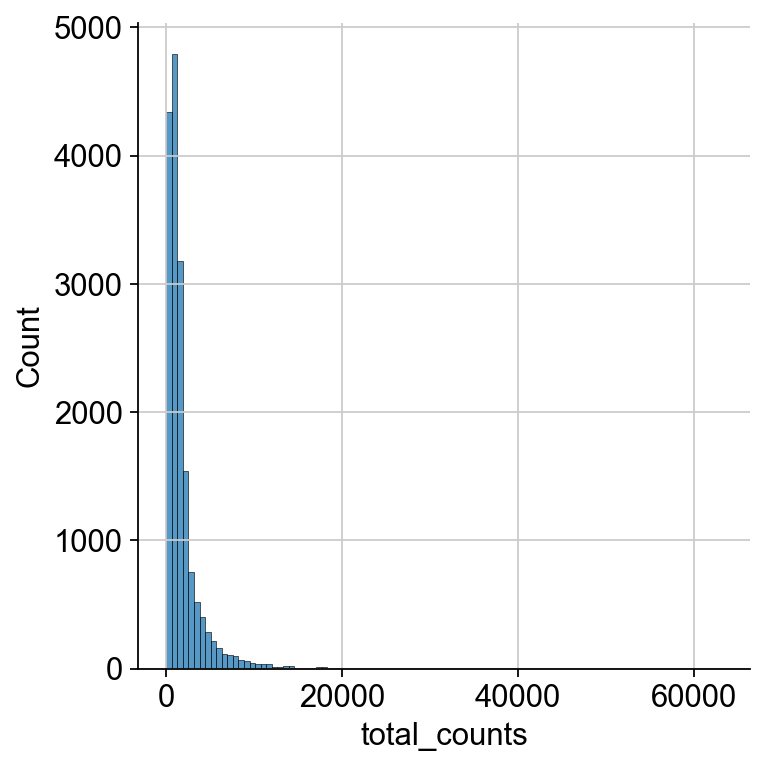

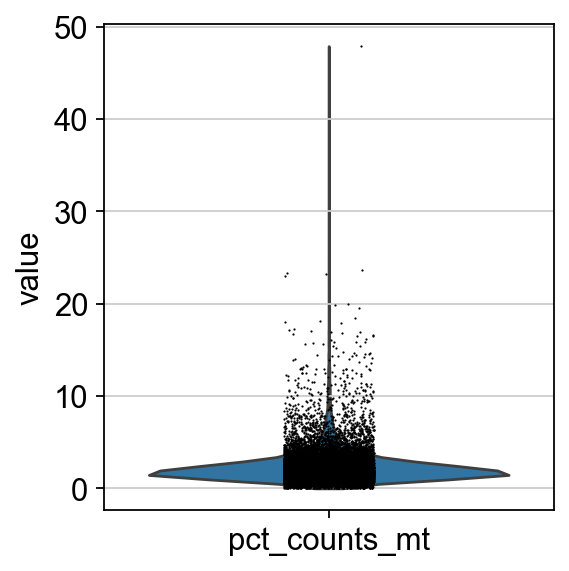

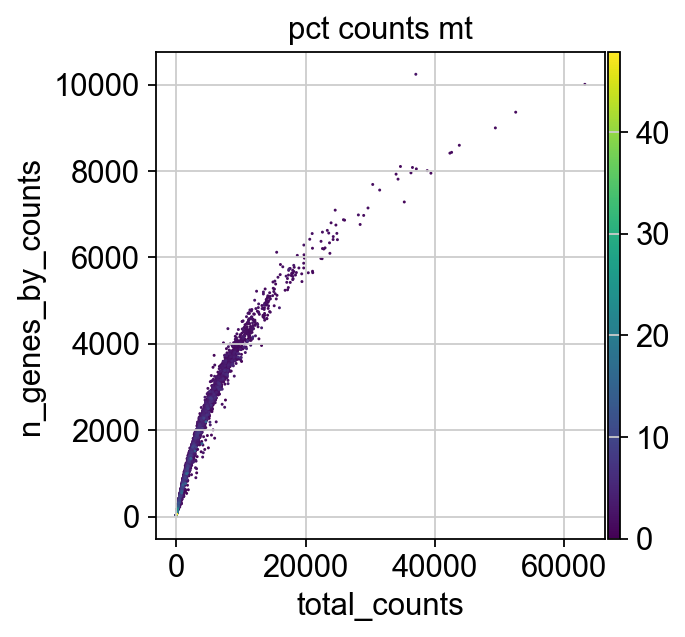

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

The plots indicate that some cells have a relatively high percentage of mitochondrial counts which are often associated with cell degradation.
But since number of counts per cell is sufficiently high and the percentage of mitochondrial reads is for most cells below 20 % we can still process the data.
Based on these plots, one could now also define manual thresholds for filtering cells.
Instead, we will show QC with automatic thresholding and filtering based on MAD.

First, we define a function that takes a `metric`, i.e. a column in `.obs` and the number of MADs (`nmad`) that is still permissive within the filtering strategy.

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    16065
True       869
Name: count, dtype: int64

`pct_counts_Mt` is filtered with 3 MADs.
Additionally, cells with a percentage of mitochondrial counts exceeding 8 % are filtered out.

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    15240
True      1694
Name: count, dtype: int64

We now filter our AnnData object based on these two additional columns.

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 14814


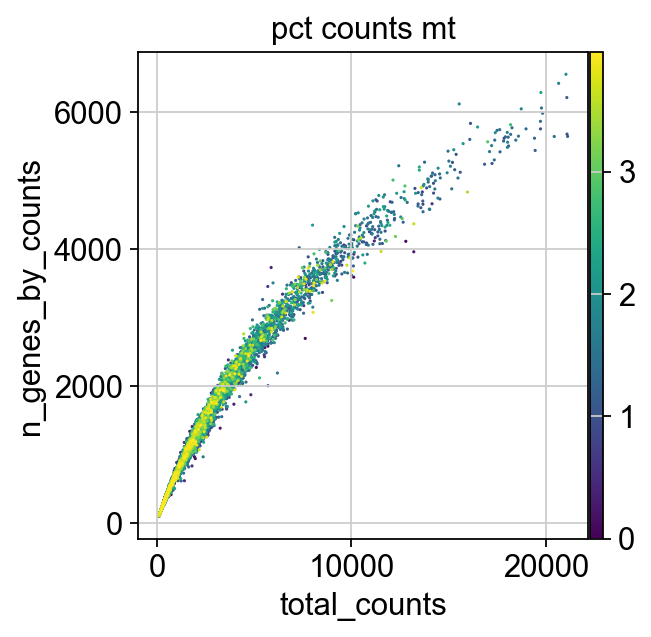

In [11]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Correction of ambient RNA

For droplet-based single cell RNA-seq experiments, a certain amount of background mRNAs is present in the dilution that gets distributed into the droplets with cells and sequenced along with them.
The net effect of this is to produce a background contamination that represents expression not from the cell contained within a droplet, but the solution that contained the cells.

Droplet-based scRNA-seq generates counts of {term}`unique molecular identifiers (UMIs) <Unique Molecular Identifier (UMI)>` for genes across multiple cells and aims to identify the number of molecules for each gene and each cell.
It assumes that each droplet contains mRNA from single cells.
{term}`Doublet <Doublets>`, empty droplets and cell-free RNA can violate this assumption.
Cell-free mRNA molecules represent background mRNA that is present in the dilution.
These molecules get distributed along the droplets and are sequenced along with them.
This contamination of cell-free mRNA in the input solution is typically called "the soup" which is created by cell lysis.

:::{figure-md} ambient RNA

<img src="../_static/images/preprocessing_visualization/ambient_rna.jpeg" alt="Ambient RNA Overview" class="bg-primary mb-1" width="800px">

In droplet-based sequencing technologies, droplets can incorporate ambient RNA or doublets (droplets with multiple cells captured).
Contaminating ambient RNA is barcoded and counted together with the native mRNA from the cell leading to confounded counts. 

:::

Cell-free mRNA molecules, also known as ambient RNA, can confound the number of observed counts and can be seen as background contamination.
It is important to correct droplet-based scRNA-seq datasets for cell-free mRNA as it may distort the interpretation of the data in our downstream analysis.
Generally, the soup differs for each input solution and depends on the expression pattern across individual cells in the dataset.
Methods for removal of ambient mRNA like SoupX {cite}`qc:Young2020` and DecontX {cite}`decontX_yang_decontamination_2020` aim to estimate the composition of the soup and correct the count table with respect to the soup-based expression.

As a first step, SoupX calculates the profile of the soup. It estimates the ambient mRNA expression profile from empty droplets as given by the unfiltered Cellranger matrix.
Next, SoupX estimates the cell-specific contamination fraction.
Lastly, it corrects the expression matrix according to the ambient mRNA expression profile and the estimated contamination.

The output of SoupX is a modified counts matrix, which can be used for any downstream analysis tool. 


We now load the required python and R packages needed for running SoupX.

In [12]:
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

rcb.logger.setLevel(logging.ERROR)


%load_ext rpy2.ipython

In [13]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

SoupX can be run without clustering information, however as Young and Behjati{cite}`qc:Young2020` note that the results are better if a basic clustering is provided.
SoupX can be used with the default clustering produced by Cellranger or by manually defining clusters.
We will showcase the latter in this notebook as the results from SoupX are not strongly sensitive to the clustering used. 

We now create a copy of our AnnData object, normalize it, reduce its dimensionality and compute default Leiden clusters on the processed copy.
A subsequent chapter introduces clustering in more detail.
For now, we just need to know that Leiden clustering gives us partitions (communities) of cells in our dataset.
We save the obtained clusters as `soupx_groups` and delete the copy of the AnnData object to save some memory in our notebook.  

Firstly, we generate a copy of our AnnData object, normalize and log1p transform it.
We use simply shifted logarithm normalization at this point.
More information on different normalization techniques can be found in the [normalization chapter](normalization.ipynb).

In [14]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4)
sc.pp.log1p(adata_pp)

Next, we compute the principle components of the data to obtain a lower dimensional representation.
This representation is then used to generate a neighbourhood graph of the data and run leiden clustering on the KNN-graph.
We add the clusters as `soupx_groups` to `.obs` and save them as a vector. 

In [15]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(
    adata_pp, key_added="soupx_groups", flavor="igraph", n_iterations=2, directed=False
)

# Preprocess variables for SoupX
adata.obs["soupx_groups"] = adata_pp.obs["soupx_groups"]

We can now delete the copy of our AnnData object as we generated a vector of clusters which can be used in soupX.

In [16]:
del adata_pp

Next, we save the cell names, gene names, and the data matrix of the filtered cellranger output.
SoupX requires a matrix of shape features x barcodes, so we have to transpose `.X`. 

In [17]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

SoupX additionally requires the raw gene by cells matrix which is typically called `raw_feature_bc_matrix.h5` in the cellranger output.
We load this similarly as before the `filtered_feature_bc_matrix.h5` with `lamindb` and run `.var_names_make_unique()` on the object and transpose the respective `.X`. 

In [18]:
adata_raw = af.load()
adata_raw.var_names_make_unique()

genes_raw = adata_raw.var_names
cells_raw = adata_raw.obs_names

data_tod = adata_raw.X.T

/Users/seohyon/miniconda3/envs/preprocessing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
del adata_raw

We now need to convert the data into the right structure to be used in R.

In [20]:
data_csc = data.tocsc()
data_tod_csc = data_tod.tocsc()

# Extract sparse components and cast to correct types
x = data_csc.data.astype(np.float64)
i = data_csc.indices.astype(np.int32)
p = data_csc.indptr.astype(np.int32)
dims = np.array(data_csc.shape, dtype=np.int32)

x_tod = data_tod_csc.data.astype(np.float64)
i_tod = data_tod_csc.indices.astype(np.int32)
p_tod = data_tod_csc.indptr.astype(np.int32)
dims_tod = np.array(data_tod_csc.shape, dtype=np.int32)

with localconverter(ro.default_converter + pandas2ri.converter + numpy2ri.converter):
    ro.globalenv["x"] = x
    ro.globalenv["i"] = i
    ro.globalenv["p"] = p
    ro.globalenv["dims"] = dims

    ro.globalenv["x_tod"] = x_tod
    ro.globalenv["i_tod"] = i_tod
    ro.globalenv["p_tod"] = p_tod
    ro.globalenv["dims_tod"] = dims_tod

    ro.globalenv["genes"] = np.array(genes)
    ro.globalenv["genes_raw"] = np.array(genes_raw)
    ro.globalenv["cells"] = np.array(cells)
    ro.globalenv["cells_raw"] = np.array(cells_raw)
    ro.globalenv["soupx_groups"] = adata.obs["soupx_groups"].to_numpy()

We now have everything in place to run SoupX.
The inputs are the filtered cellranger matrix of shape barcodes x cells, the raw table of droplets from cellranger of shape `barcodes x droplets`, the gene and cell names and the clusters obtained by simple leiden clustering.
The output will be the corrected count matrix. 

We first construct a so called `SoupChannel` from the table of droplets and the table of cells.
Next, we add metadata to the SoupChannel object which can be any metadata in the form of a `data.frame`.

In [21]:
%%R -o out 

library(Matrix)

# Manually coerce types to avoid "array" class errors
x <- as.numeric(x)
i <- as.integer(i)
p <- as.integer(p)
dims <- as.integer(dims)

x_tod <- as.numeric(x_tod)
i_tod <- as.integer(i_tod)
p_tod <- as.integer(p_tod)
dims_tod <- as.integer(dims_tod)

# Reconstruct sparse matrices
data <- new("dgCMatrix",
            Dim = dims,
            x = x,
            i = i,
            p = p)

data_tod <- new("dgCMatrix",
                Dim = dims_tod,
                x = x_tod,
                i = i_tod,
                p = p_tod)

# Assign row and column names
rownames(data) <- genes
colnames(data) <- cells
rownames(data_tod) <- genes_raw
colnames(data_tod) <- cells_raw

# SoupX pipeline
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

soupProf = data.frame(
  row.names = rownames(data),
  est = rowSums(data) / sum(data),
  counts = rowSums(data)
)
sc = setSoupProfile(sc, soupProf)
sc = setClusters(sc, soupx_groups)
sc = autoEstCont(sc, doPlot = FALSE)
out = adjustCounts(sc, roundToInt = TRUE)

SoupX successfully inferred corrected counts, which we can now store as an additional layer.
In all following analysis steps, we would like to use the SoupX corrected count matrix, so we overwrite `.X` with the soupX corrected matrix.
First, as we did before from python to R, we convert the matrix from R to python.

In [22]:
with localconverter(ro.default_converter + pandas2ri.converter + numpy2ri.converter):
    out_py = ro.conversion.rpy2py(ro.globalenv["out"])

x = np.array(out_py.slots["x"])
i = np.array(out_py.slots["i"])
p = np.array(out_py.slots["p"])
shape = tuple(out_py.slots["Dim"])

out_matrix = csc_matrix((x, i, p), shape=shape)

In [23]:
adata.layers["counts"] = adata.X.copy()
adata.layers["soupX_counts"] = out_matrix.T
adata.X = adata.layers["soupX_counts"]

Next, we additionally filter out genes that are not detected in at least 20 cells as these are not informative.
This exclusion is necessary because genes detected in very few cells are often the result of technical noise, ambient RNA contamination, or stochastic low-level transcription, rather than true biological signal.
Including such lowly detected genes can introduce noise, obscure meaningful biological patterns, and complicate downstream analyses like clustering, differential expression testing, or trajectory inference.
By setting a minimum detection threshold (e.g., 20 cells), we focus the analysis on genes that are consistently observed across multiple cells, improving the reliability and interpretability of the results.

In [24]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 20234


(preprocessing-visualization-quality-control-key-takeaway-3)=
(preprocessing-visualization-quality-control-key-takeaway-4)=
(rna:doublet-detection)=
## Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, if they were captured in the same droplet.
That's why we used the term "barcode" instead of "cell" until now.
A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise.
Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs.
Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic.
Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps.
Hence, doublet detection and removal are typically initial preprocessing steps.
Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset.
Doublet detection methods are computationally efficient and there exist several software packages for this task. 

{cite}`xi_benchmarking_2021` benchmarked nine different doublet detection methods and assessed their performance with respect to computational efficiency and doublet detection accuracy.
They additionally assessed scDblFinder in an addendum to their benchmark which achieved the highest doublet detection accuracy and a good computational efficiency and stability {cite}`Xi_2021_addendum`.

In this tutorial, we will showcase the scDblFinder R package.
scDblFinder randomly selects two droplets and creates artificial doublets from those by averaging their gene expression profiles.
The doublet score is then defined as the fraction of artificial doublets in the k-nearest neighbor graph of each droplet in the principal component space.

:::{figure-md} Doublet detection

<img src="../_static/images/preprocessing_visualization/doublet_detection.jpeg" alt="Doublet detection overview" class="bg-primary mb-1" width="800px">

Doublets are droplets that contain more than one cell.
Common doublet detection methods generate artificial doublets by randomly subsampling pairs of cells and averaging their gene expression profile to obtain doublet counts.
These artificial doublets are projected together with the remaining calls into a lower dimensional principal component space.
The doublet detection method computes a doublet score based on the number of artificial doublet neighbors in the k nearest neighbor graph.

:::

We first load some additional R packages.

In [25]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(SingleCellExperiment)
library(BiocParallel)

In [26]:
data_mat = adata.X.T

We can now launch the doublet detection by using data_mat as input to scDblFinder within a SingleCellExperiment.
`scDblFinder` adds several columns to the colData of sce.
Three of them might be interesting for the analysis:

* `sce$scDblFinder.score`: the final doublet score (the higher the more likely that the cell is a doublet)

* `sce$scDblFinder.ratio` : the ratio of artificial doublets in the cell's neighborhood

* `sce$scDblFinder.class` : the classification (doublet or singlet)

We will only output the class argument and store it in the AnnData object in `.obs` .
The other arguments can be added to the AnnData object similarly.

Again, we first have to convert the matrix from python to R.

In [27]:
data_mat = adata.X.T.tocsc()

x = data_mat.data.astype(np.float64)
i = data_mat.indices.astype(np.int32)
p = data_mat.indptr.astype(np.int32)
dims = np.array(data_mat.shape, dtype=np.int32)

with localconverter(ro.default_converter + numpy2ri.converter):
    ro.globalenv["x"] = x
    ro.globalenv["i"] = i
    ro.globalenv["p"] = p
    ro.globalenv["dims"] = dims

Now:

In [28]:
%%R -o doublet_score -o doublet_class

x <- as.numeric(x)
i <- as.integer(i)
p <- as.integer(p)
dims <- as.integer(dims)

data_mat <- new("dgCMatrix", Dim = dims, x = x, i = i, p = p)

set.seed(123)
sce <- scDblFinder(SingleCellExperiment(list(counts = data_mat)))

doublet_score <- sce$scDblFinder.score
doublet_class <- sce$scDblFinder.class

scDblFinder outputs a class with the classification `Singlet` (1) and `Doublet` (2).
We add this to our AnnData object in `.obs`.

In [29]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    12028
doublet     2786
Name: count, dtype: int64

We advise to leave identified doublets in the dataset for now and inspect doublets during visualization.

During downstream clustering it might be useful to reassess quality control and the chosen parameters to potentially filter out more or less cells.
We will now save the dataset into `lamindb`, so that we can continue with the [normalization chapter](normalization.ipynb).

In [30]:
af = ln.Artifact.from_anndata(
    adata,
    key="preprocessing_visualization/s4d8_quality_control.h5ad",
    description="anndata after quality control",
).save()
af

→ creating new artifact version for key='preprocessing_visualization/s4d8_quality_control.h5ad' (storage: 's3://lamin-eu-central-1/VPwcjx3CDAa2')
... uploading Y8EIAWzUB42V1j3S0006.h5ad: 100.0%
! The cache path /Users/seohyon/Library/Caches/lamindb/lamin-eu-central-1/VPwcjx3CDAa2/preprocessing_visualization/s4d8_quality_control.h5ad already exists, replacing it.


Artifact(uid='Y8EIAWzUB42V1j3S0006', is_latest=True, key='preprocessing_visualization/s4d8_quality_control.h5ad', description='anndata after quality control', suffix='.h5ad', kind='dataset', otype='AnnData', size=527008638, hash='QgZM9CgjIxUKp15Jm-aU_Q', n_observations=14814, space_id=1, storage_id=1, run_id=7, created_by_id=5, created_at=2025-05-30 16:53:49 UTC)

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: qc
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar
* Seo H. Kim silly girl

### Reviewers

* Lukas Heumos
* Luke Zappia
